In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker, MarkerCluster
from IPython.display import display, Markdown

In [3]:
#Reading and Cleaning Data
acled_data = pd.read_csv('./ACLED_DATA_PREVIOUSYEAR.csv') 
gdf = gpd.GeoDataFrame(
    acled_data, geometry=gpd.points_from_xy(acled_data.longitude, acled_data.latitude), crs="EPSG:4326"
)
filtered_gdf = gdf[gdf['fatalities']>0]
ua = gpd.read_file("./ua.json")
roads = gpd.read_file("./Ukraine_-_roads/Ukraine_-_roads.shp")
roads.to_crs("EPSG:4326")


,FID,MED_DESCRI,RTT_DESCRI,F_CODE_DES,ISO,ISOCOUNTRY,Shape__Len,geometry
0,1,Unknown,Unknown,Road,UKR,UKRAINE,39558.773041,"LINESTRING (38.5872 49.09414, 38.58469 49.0868..."
1,2,Unknown,Unknown,Road,UKR,UKRAINE,7772.898511,"LINESTRING (26.93383 49.08428, 26.93942 49.091..."
2,3,Without Median,Secondary Route,Road,UKR,UKRAINE,32925.829008,"LINESTRING (30.94397 49.0835, 30.93869 49.0843..."
3,4,Without Median,Secondary Route,Road,UKR,UKRAINE,12410.778666,"LINESTRING (38.82147 49.08294, 38.82214 49.113..."
4,5,Without Median,Secondary Route,Road,UKR,UKRAINE,17061.784837,"LINESTRING (33.77845 49.17197, 33.76989 49.169..."
...,...,...,...,...,...,...,...,...
6790,6791,Without Median,Primary Route,Road,UKR,None,121.576594,"LINESTRING (26.80669 48.25084, 26.80674 48.25011)"
6791,6792,Without Median,Primary Route,Road,UKR,None,1752.601947,"LINESTRING (22.87774 47.98843, 22.86856 47.97987)"
6792,6793,Without Median,Primary Route,Road,UKR,None,2261.958812,"LINESTRING (28.37478 45.52785, 28.36043 45.51777)"
6793,6794,Without Median,Primary Route,Road,UKR,None,3325.456951,"LINESTRING (28.35388 45.5184, 28.35128 45.5243..."


<Axes: >

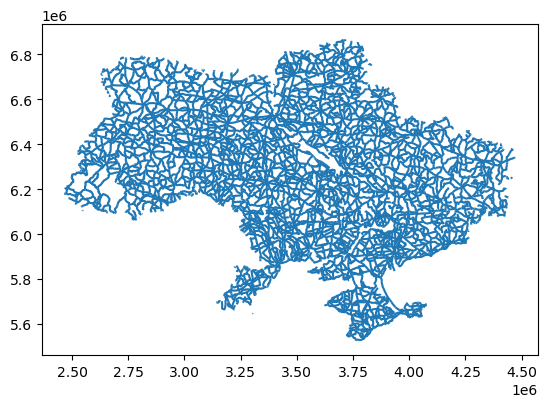

In [4]:
roads.plot()

In [5]:
def maximum_coverage(demand_points, facility_locations, num_facilities, service_radius):
    """
    Implements the maximum coverage algorithm.

    Args:
        demand_points: GeoDataFrame with demand points.
        facility_locations: GeoDataFrame with candidate facility locations.
        num_facilities: Number of facilities to select.
        service_radius: Service radius around each facility.

    Returns:
        GeoDataFrame of selected facilities.
    """

    selected_facilities = []
    covered_demand = []

    for _ in range(num_facilities):
        max_coverage = 0
        best_facility = None

        for _, facility in facility_locations.iterrows():
            if facility.geometry in selected_facilities:
                continue

            service_area = facility.geometry.buffer(service_radius)
            covered = demand_points[demand_points.geometry.within(service_area)]
            coverage = covered.shape[0]

            if coverage > max_coverage:
                max_coverage = coverage
                best_facility = facility

        if best_facility is not None:
            selected_facilities.append(best_facility.geometry)
            covered_demand.extend(covered_demand)

    return gpd.GeoDataFrame(geometry=selected_facilities, crs="EPSG:4326")

Total points: 6795


<Axes: title={'center': '1 Point per road'}>

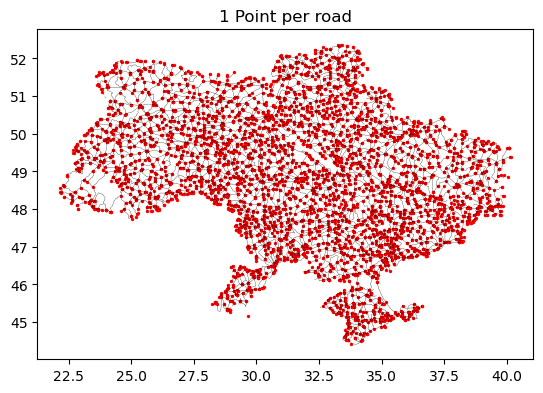

In [7]:
points = []

for index, row in roads.to_crs(filtered_gdf.crs).iterrows():    
    distances = np.linspace(0, row['geometry'].length, 1)
    points.extend([row['geometry'].interpolate(distance) for distance in distances])

print("Total points: " + str(len(points)))

points_gdf = gpd.GeoDataFrame({'geometry': points})

f, ax = plt.subplots()
ax.title.set_text("1 Point per road")
points_gdf.plot(ax=ax, markersize=2, color="RED")
roads.to_crs(filtered_gdf.crs).plot(ax=ax,linewidth=0.2, edgecolor='black')

<Axes: title={'center': 'maximum coverage points'}>

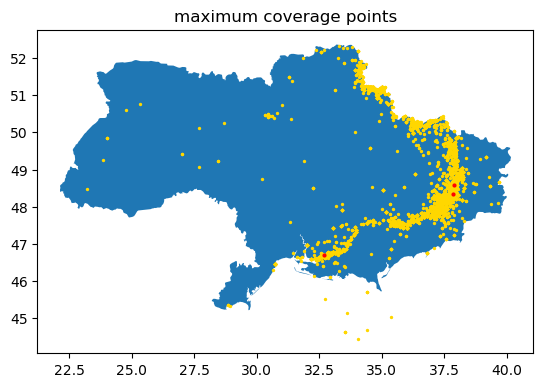

In [8]:
places = maximum_coverage(filtered_gdf, points_gdf, 3, .1) # .05 for the service_radius is a radius of ~5km

f, ax = plt.subplots()
ax.title.set_text("maximum coverage points")
ua.plot(ax=ax)
filtered_gdf.plot(ax=ax, color="gold", markersize=2)
places.to_crs(ua.crs).plot(ax=ax, color="red", markersize=4)

In [9]:
import folium
from folium.plugins import HeatMap

m = folium.Map()

# Extract latitude and longitude from the geometry column
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in filtered_gdf.geometry]

# Add the heatmap layer
HeatMap(heat_data).add_to(m)

# Add the GeoDataFrame to the map
folium.GeoJson(places).add_to(m)

m

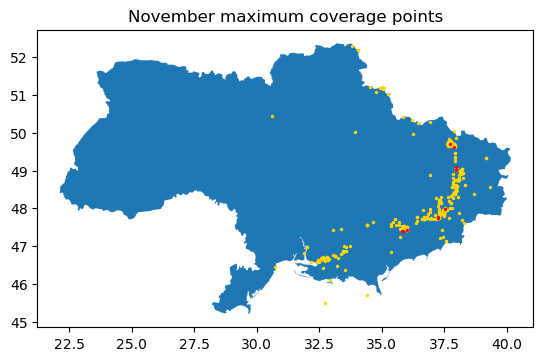

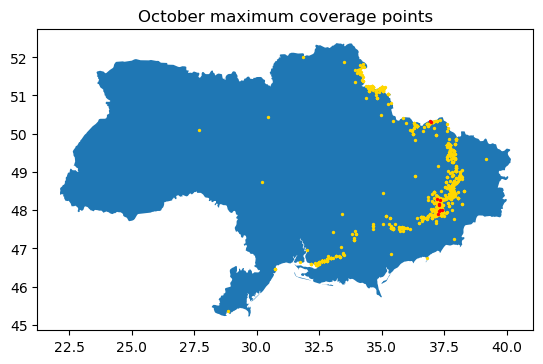

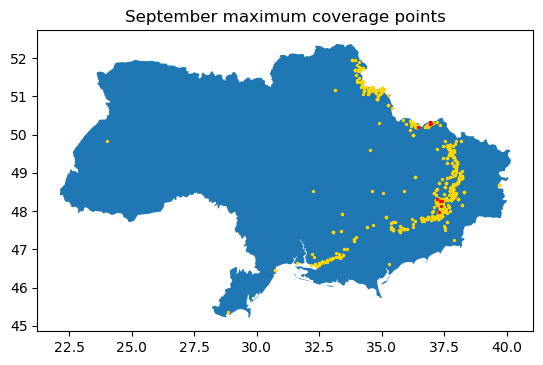

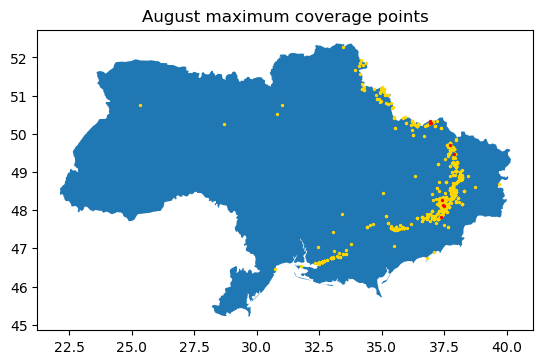

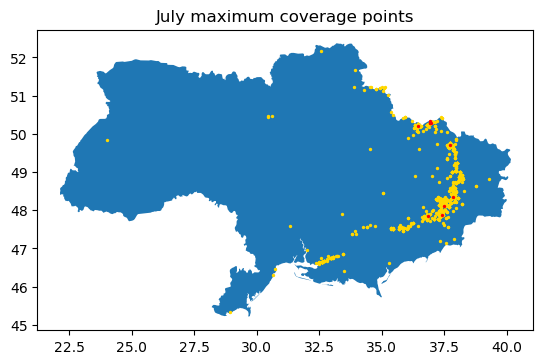

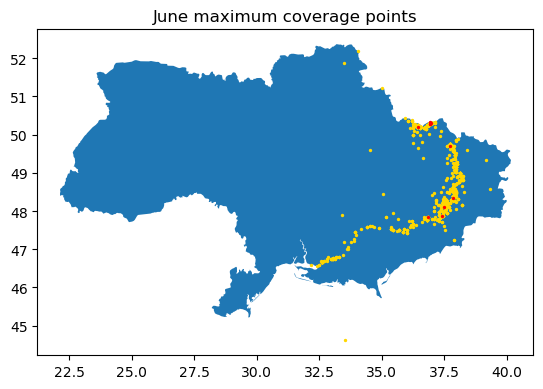

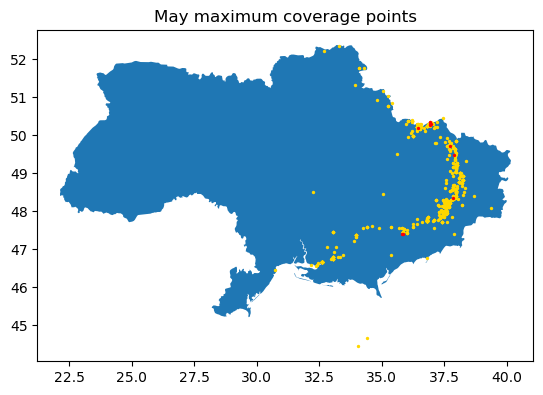

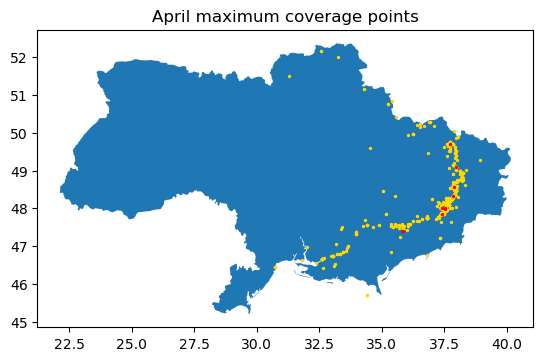

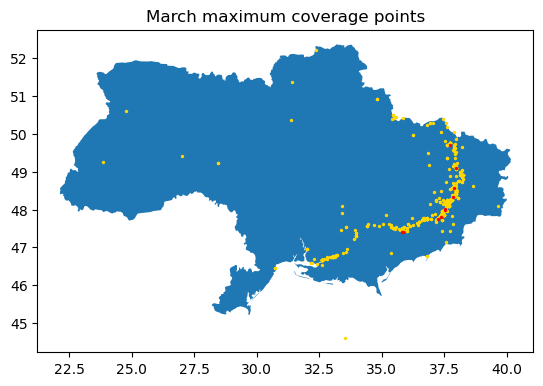

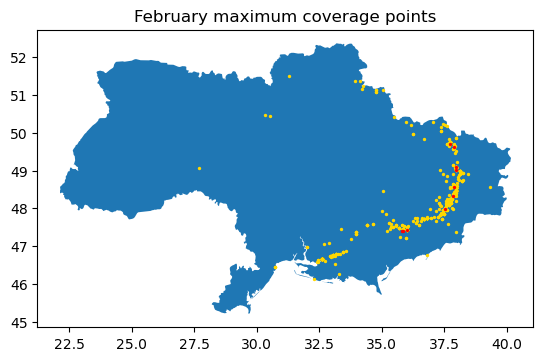

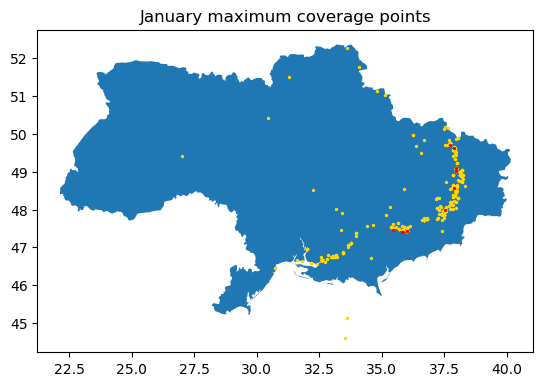

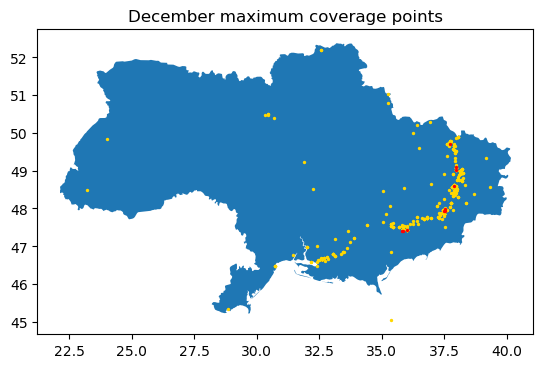

In [10]:
months = ["November","October","September","August","July","June","May","April","March","February","January","December"]

for month in months:
    places = maximum_coverage(filtered_gdf[filtered_gdf['event_date'].str.contains(month)], points_gdf, 10, .05) # .05 for the service_radius is a radius of ~5km

    f, ax = plt.subplots()
    ax.title.set_text(month + " maximum coverage points")
    ua.plot(ax=ax)
    filtered_gdf[filtered_gdf['event_date'].str.contains(month)].plot(ax=ax, color="gold", markersize=2)
    places.to_crs(ua.crs).plot(ax=ax, color="red", markersize=2)

### Ranking Towns Based on Road Infrastructure and Conflict Proximity

In [18]:

# Ensure CRS consistency between datasets
roads = roads.to_crs("EPSG:3857")
filtered_gdf = filtered_gdf.to_crs("EPSG:3857")

# Define a buffer around conflict zones (e.g., 50 km)
conflict_buffer = filtered_gdf.buffer(50000)

# Calculate road density around conflict zones
road_density = gpd.sjoin(roads, gpd.GeoDataFrame(geometry=conflict_buffer), how='inner', predicate='intersects')

road_density['road_length'] = road_density.geometry.length

# Summarize road length per conflict zone
road_length_summary = road_density.groupby('index_right')['road_length'].sum().reset_index()
road_length_summary.columns = ['conflict_zone', 'total_road_length']

# Merge back to the conflict dataset
filtered_gdf['total_road_length'] = filtered_gdf.index.map(
    road_length_summary.set_index('conflict_zone')['total_road_length']
)
filtered_gdf['total_road_length'] = filtered_gdf['total_road_length'].fillna(0)


In [28]:

# Ensure CRS is consistent
roads = roads.to_crs("EPSG:3857")
filtered_gdf = filtered_gdf.to_crs("EPSG:3857")

# Calculate intersections
intersections = gpd.overlay(roads, roads, how='intersection')

# Drop duplicate intersections
intersections['geometry'] = intersections.geometry.apply(lambda geom: geom.centroid)
intersections = intersections.drop_duplicates(subset='geometry')

# Add buffer around intersections to calculate road density
intersections['buffer'] = intersections.geometry.buffer(5000)  # 5 km buffer

# Spatial join to find roads within the buffer
intersections_with_roads = gpd.sjoin(roads, gpd.GeoDataFrame(intersections, geometry=intersections['buffer']), how='inner', predicate='intersects')

# Calculate road density
intersections_with_roads['road_length'] = intersections_with_roads.geometry.length
road_density = intersections_with_roads.groupby('index_right')['road_length'].sum().reset_index()
road_density.columns = ['intersection', 'total_road_length']

# Merge road density back to intersections
intersections = intersections.reset_index()
intersections['total_road_length'] = intersections['index'].map(
    road_density.set_index('intersection')['total_road_length']
)
intersections['total_road_length'] = intersections['total_road_length'].fillna(0)

# Calculate proximity to conflict zones
intersections['distance_to_conflict'] = intersections.geometry.apply(
    lambda x: filtered_gdf.distance(x).min()
)

# Normalize scores
intersections['road_score'] = (intersections['total_road_length'] - intersections['total_road_length'].min()) / (
    intersections['total_road_length'].max() - intersections['total_road_length'].min()
)
intersections['conflict_score'] = (intersections['distance_to_conflict'] - intersections['distance_to_conflict'].min()) / (
    intersections['distance_to_conflict'].max() - intersections['distance_to_conflict'].min()
)
intersections['conflict_score'] = 1 - intersections['conflict_score']  # Invert conflict score to prefer safer areas

# Combine scores
intersections['final_score'] = intersections['road_score'] * 0.6 + intersections['conflict_score'] * 0.4

# Sort by final score
ranked_intersections = intersections.sort_values(by='final_score', ascending=False)
ranked_intersections.head()

# Filter intersections on the Ukrainian side
# Define a rough boundary for the "Ukrainian side" (can use polygons for better accuracy)
ukraine_boundary = filtered_gdf.total_bounds  # xmin, ymin, xmax, ymax
xmin, ymin, xmax, ymax = ukraine_boundary
ukrainian_side = xmin + (xmax - xmin) * 0.5  # Midpoint of the map

# Keep points east of the midpoint (Ukrainian side)
ranked_intersections = ranked_intersections[ranked_intersections.geometry.x < ukrainian_side]

# Apply a threshold for the top 10%
score_threshold = ranked_intersections['final_score'].quantile(0.9)
top_intersections = ranked_intersections[ranked_intersections['final_score'] >= score_threshold]


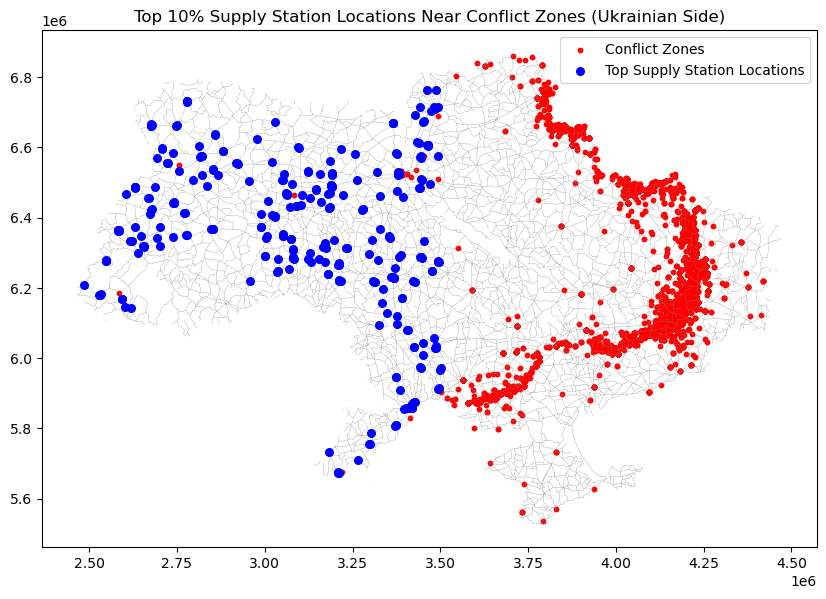

In [29]:

# Convert intersections to WGS84 for visualization
ranked_intersections = ranked_intersections.to_crs("EPSG:4326")

# Initialize a map centered on Ukraine
m = folium.Map(location=[48.3794, 31.1656], zoom_start=6)

# Add intersections to the map
for _, row in ranked_intersections.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        popup=f"Intersection: Score {row['final_score']:.2f}",
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
    ).add_to(m)

# Display the map
m

# Plot top intersections near conflict zones on the Ukrainian side
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Top 10% Supply Station Locations Near Conflict Zones (Ukrainian Side)")

# Plot the roads
roads.plot(ax=ax, linewidth=0.2, edgecolor='gray')

# Plot the conflict zones
filtered_gdf.plot(ax=ax, color='red', markersize=10, label="Conflict Zones")

# Plot the top intersections
top_intersections.plot(
    ax=ax,
    color='blue',
    markersize=30,
    label="Top Supply Station Locations",
    zorder=3,
)

plt.legend()
plt.show()
